# Mini-Batch Stochastic Gradient Descent


In [1]:
!pip install mxnet
!pip install d2l

     |████████████████████████████████| 25.4MB 55.7MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=3eae84de403793f50023b36c4d29c9bf15994522d5a0642c238769f6b4c03f2a
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l


In [0]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import numpy as np
import time

## Reading Data

In [3]:
def get_data_ch7():  
    data = np.genfromtxt('https://raw.githubusercontent.com/d2l-ai/d2l-en/master/data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return nd.array(data[:1500, :-1]), nd.array(data[:1500, -1])

features, labels = get_data_ch7()
features.shape

(1500, 5)

## Implementation from Scratch


In [0]:
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

The training function

In [0]:
def train_ch7(trainer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    net, loss = d2l.linreg, d2l.squared_loss
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()
    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()
    ls, ts = [eval_loss()], [0,]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    start = time.time()
    for _ in range(num_epochs):
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X, w, b), y).mean()  
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            if (batch_i + 1) * batch_size % 10 == 0:
                ts.append(time.time() - start + ts[-1])
                ls.append(eval_loss())
                start = time.time()
    print('loss: %f, %f sec per epoch' % (ls[-1], ts[-1]/num_epochs))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')
    return ts, ls

Gradient descent

loss: 0.246095, 0.022212 sec per epoch


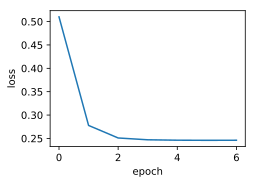

In [6]:
def train_sgd(lr, batch_size, num_epochs=2):
    return train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
gd_res = train_sgd(1, 1500, 6)

SGD

loss: 0.242902, 2.399496 sec per epoch


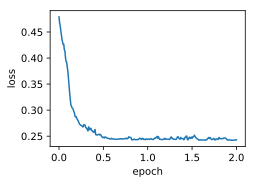

In [7]:
sgd_res = train_sgd(0.005, 1)

Mini-batch with batch size 100.

loss: 0.243460, 0.052096 sec per epoch


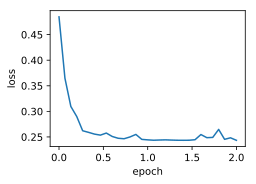

In [8]:
mini1_res = train_sgd(.4, 100)

Mini-batch with batch size 10.

loss: 0.245130, 0.247591 sec per epoch


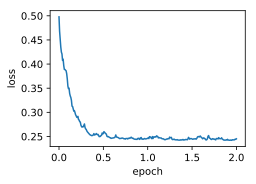

In [9]:
mini2_res = train_sgd(.05, 10)

Compare time versus loss

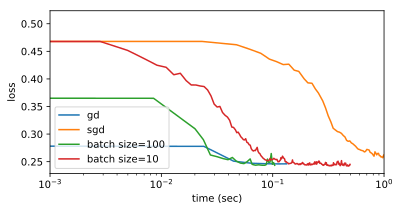

In [10]:
d2l.set_figsize([6, 3])
for res in [gd_res, sgd_res, mini1_res, mini2_res]:
    d2l.plt.plot(res[0], res[1])
d2l.plt.xlabel('time (sec)')
d2l.plt.ylabel('loss')
d2l.plt.xscale('log')
d2l.plt.xlim([1e-3, 1])
d2l.plt.legend(['gd', 'sgd', 'batch size=100', 'batch size=10']);

## Implementation with Gluon


In [0]:
def train_gluon_ch7(trainer_name, trainer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    loss = gloss.L2Loss()
    def eval_loss():
        return loss(net(features), labels).mean().asscalar()
    ls = [eval_loss()]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size) 
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

Repeat the last experiment.

loss: 0.252032, 0.243741 sec per epoch


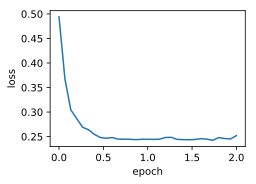

In [12]:
train_gluon_ch7('sgd', {'learning_rate': 0.05}, features, labels, 10)

##Implementation with Keras

Train on 1200 samples, validate on 300 samples
Epoch 1/10
 - 0s - loss: 1.9166 - val_loss: 0.9405
Epoch 2/10
 - 0s - loss: 0.7659 - val_loss: 0.9228
Epoch 3/10
 - 0s - loss: 0.7643 - val_loss: 0.9279
Epoch 4/10
 - 0s - loss: 0.7634 - val_loss: 0.9193
Epoch 5/10
 - 0s - loss: 0.7645 - val_loss: 0.9238
Epoch 6/10
 - 0s - loss: 0.7638 - val_loss: 0.9189
Epoch 7/10
 - 0s - loss: 0.7620 - val_loss: 0.9164
Epoch 8/10
 - 0s - loss: 0.7621 - val_loss: 0.9147
Epoch 9/10
 - 0s - loss: 0.7631 - val_loss: 0.9328
Epoch 10/10
 - 0s - loss: 0.7648 - val_loss: 0.9215


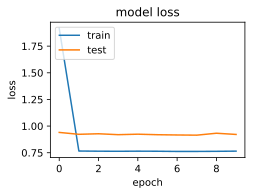

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, initializers, optimizers
from matplotlib import pyplot as plt
import numpy as np


X = features.asnumpy()
y = labels.asnumpy()
num_inputs=X.shape[1]
model = Sequential()
model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                kernel_regularizer=regularizers.l2(1), input_shape=(num_inputs,)))
sgd = optimizers.SGD(lr=0.05)
model.compile(optimizer=sgd, loss='mean_squared_error')
history = model.fit(X, y, epochs=10, verbose=2, validation_split=0.2,
                    batch_size=64)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
